### Data Load

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)

In [2]:
gs = pd.read_csv('.csv', encoding = 'EUC-KR')

In [3]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   회사명       35 non-null     object 
 1   연도        35 non-null     int64  
 2   거래소코드     35 non-null     int64  
 3   회계년도      35 non-null     object 
 4   자산총계(요약)  35 non-null     int64  
 5   부채총계      35 non-null     int64  
 6   자본총계      35 non-null     int64  
 7   매출액       35 non-null     int64  
 8   매출원가      35 non-null     int64  
 9   매출총이익     35 non-null     int64  
 10  판매비와 관리비  35 non-null     int64  
 11  영업이익      35 non-null     int64  
 12  당기순이익     35 non-null     int64  
 13  유동자산      35 non-null     int64  
 14  유동부채      35 non-null     int64  
 15  비유동부채     35 non-null     int64  
 16  자본금       35 non-null     int64  
 17  비유동자산     35 non-null     int64  
 18  총자산수익률    35 non-null     float64
 19  자기자본수익률   35 non-null     float64
 20  영업이익률     35 non-null     float64


In [20]:
def find_upper_lower_bound(col):
    temp = sorted(df[col])
    q1, q3 = np.percentile(temp, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

In [21]:
def range_check_correct(df,col):
    cor_range = find_upper_lower_bound(col)
    print(cor_range)
    for i in df.index:
        if df.loc[i][col] < (float)(cor_range[0]) :
            df[col][i] = (float)(cor_range[0])
        if df.loc[i][col] > (float)(cor_range[1]) :
            df[col][i] = (float)(cor_range[1])
    return df

In [22]:
df = range_check_correct(df, '영업이익')

(-2109632.5, 3674507.5)


In [23]:
df

,자본총계,당기순이익,부채총계,매출총이익,영업이익
0,50032,1672,265088,20548,2244
1,52840,2452,272348,36021,10583
2,55381,2523,346239,39006,12977
3,55925,7068,360890,41514,17345
4,183125,14289,486974,75470,44101
5,229293,17414,662586,97313,59425
6,229490,10219,1088274,104746,59415
7,232680,5550,1229340,143773,89192
8,238280,-48947,1392061,71118,10744
9,287286,18558,1467188,158047,91651


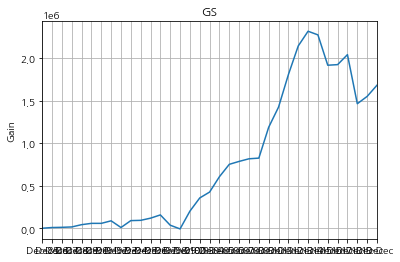

In [25]:
x = gs['회계년도']
plt.title('GS')
plt.ylabel('Gain')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.rcParams['font.family'] = 'NanumGothic'
plt.plot(x,gs['영업이익'])
plt.show()

## LSTM + F.C

### Data_setting

In [5]:
def data_setting(df):
    df = df.values.astype(float)

    test_data_size = 1
    train_data = df[:-test_data_size]
    test_data = df[-test_data_size:]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    
    return train_data_normalized, test_data, scaler

### Create_inout_sequences
in : train_data_normalized, feature_window, period
1. LSTM에 들어갈 input data를 데이터 주기와 피쳐수를 기반으로 sequence를 생성

out : sequence

In [6]:
def create_inout_sequences(input_data, fw, period):
    inout_seq = []
    L = len(input_data)
    
    for i in range(0, L-period*fw, fw):
        train_seq = input_data[i:i+period*fw]
        train_label = input_data[i+(period+1)*fw-1:i+(period+1)*fw]
        inout_seq.append((train_seq ,train_label))
        
    return inout_seq

### LSTM+F.C

In [7]:
class LSTM(nn.Module):
    
    def __init__(self, fw, period, layers, hidden_layer_size = 250, output_size = 1):
        super().__init__()
        self.input_size = fw
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.period = period
        self.layers = layers


        self.lstm = nn.LSTM(self.input_size, self.hidden_layer_size, num_layers = layers)

        self.linear = nn.Sequential(
            nn.Linear(hidden_layer_size, 50),
            nn.Linear(50, self.output_size)
        )

        self.hidden_cell = (torch.zeros(layers,period,hidden_layer_size),
                       torch.zeros(layers,period,hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(-1 ,self.period, self.input_size), self.hidden_cell) 
        predictions = self.linear(lstm_out.view(self.period, self.hidden_layer_size))
        return predictions[-self.output_size:]

In [8]:
train_window = 5
period = 3
learning_rate = 0.01
layers = 3

In [9]:
df = gs.loc[:,['자본총계', '당기순이익', '부채총계', '매출총이익', '영업이익']]
train_data_normalized,test_data,scaler = data_setting(df)
train_inout_seq = create_inout_sequences(train_data_normalized, train_window, period)

In [10]:
model = LSTM(train_window,period, layers)

In [11]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        y_pred = model(seq)[0]
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01076893
epoch:  26 loss: 0.00720659
epoch:  51 loss: 0.00155022
epoch:  76 loss: 0.00014905
epoch: 101 loss: 0.01763167
epoch: 126 loss: 0.00303953
epoch: 151 loss: 0.01616964
epoch: 176 loss: 0.01435716
epoch: 201 loss: 0.01256601
epoch: 226 loss: 0.00558108
epoch: 251 loss: 0.01228831
epoch: 276 loss: 0.00840215
epoch: 301 loss: 0.01408029
epoch: 326 loss: 0.01419612
epoch: 351 loss: 0.01188700
epoch: 376 loss: 0.01024128
epoch: 401 loss: 0.00929792
epoch: 426 loss: 0.01095466
epoch: 451 loss: 0.01005101
epoch: 476 loss: 0.01021541
epoch: 499 loss: 0.0108045293


In [12]:
fut_pred = 1
test_inputs = train_data_normalized[-period*train_window:].tolist()

In [13]:
len(test_inputs)

15

In [14]:
model.eval()

for i in [1]:
    seq = torch.FloatTensor(test_inputs[-period*train_window:])
    pred = model(seq)
    with torch.no_grad():
        test_inputs.append(float(model(seq)[-1]))

In [15]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[-fut_pred:]).reshape(-1, 1))
ans = gs['영업이익'][-5:]

In [16]:
actual_predictions[0]

array([2818262.80566979])

In [17]:
ans[-1:]

34    1679617
Name: 영업이익, dtype: int64

In [18]:
RMSE = mean_squared_error(ans[-1:],actual_predictions[0])**0.5

In [19]:
RMSE

1138645.805669785